# Introduction


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot

from pprint import pprint
import scienceplots
import sys
sys.path.append("../FinRL-Library")

plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [2]:
import yahoo_fin.stock_info as si
ticks = si.tickers_ftse100(True)
sp500 = si.tickers_sp500(True)
dow = si.tickers_dow(True)
nifty = si.tickers_nifty50(True)
display(ticks.head(100))


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


Company Ticker  \
0                   3i    III   
1        Admiral Group    ADM   
2        Airtel Africa    AAF   
3   Anglo American plc    AAL   
4      Antofagasta plc   ANTO   
..                 ...    ...   
95        Vistry Group    VTY   
96      Vodafone Group    VOD   
97          Weir Group   WEIR   
98           Whitbread    WTB   
99             WPP plc    WPP   

   FTSE industry classification benchmark sector[25]  
0                                 Financial services  
1                                          Insurance  
2                        Telecommunications services  
3                                             Mining  
4                                             Mining  
..                                               ...  
95                                 Home Construction  
96                         Mobile telecommunications  
97                     Industrial goods and services  
98                                Retail hospitality  
99                                             Media  

[100 rows x 3 columns]

In [21]:
ticks_from_setctors = ticks.groupby('FTSE industry classification benchmark sector[25]',as_index=False).first().iloc[:,[2]]
ticks['FTSE industry classification benchmark sector[25]'].value_counts()

NameError: name 'ticks' is not defined

In [2]:
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'

In [ ]:
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER

df_dow = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
df_nasdaq = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = NAS_100_TICKER).fetch_data()
df_hsi = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = HSI_50_TICKER).fetch_data()
df_dax = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DAX_30_TICKER).fetch_data()

In [ ]:

df_sp500 = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = SP_500_TICKER).fetch_data()


In [103]:
df_dow.to_csv('./data/dow.csv')
df_nasdaq.to_csv('./data/nasdaq.csv')
df_hsi.to_csv('./data/hsi.csv')
df_dax.to_csv('./data/dax.csv')
df_sp500.to_csv('./data/sp500.csv')



In [3]:
from pandas import read_csv


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

In [105]:
df_dow.drop(df_dow.columns[0], axis=1,inplace=True)
df_dow.head()

date       open       high        low      close     volume   tic  \
0  2000-01-03   0.936384   1.004464   0.907924   0.844004  535796800  AAPL   
1  2000-01-03  70.000000  70.000000  62.875000  44.614418   22914900  AMGN   
2  2000-01-03  47.995617  47.995617  45.515598  32.671795    6471267   AXP   
3  2000-01-03  41.437500  41.687500  39.812500  25.940279    2638200    BA   
4  2000-01-03  23.843750  24.500000  23.843750  12.763931    5055000   CAT   

   day  
0    0  
1    0  
2    0  
3    0  
4    0

In [106]:
ticks_list = df_dow['tic'].unique()

In [107]:
df_copy = df_dow.copy()
df_copy['symbol'] = df_dow['tic']
df_copy.head()
df_close = df_copy[['symbol','close','date']]
df_close.head()

symbol      close        date
0   AAPL   0.844004  2000-01-03
1   AMGN  44.614418  2000-01-03
2    AXP  32.671795  2000-01-03
3     BA  25.940279  2000-01-03
4    CAT  12.763931  2000-01-03

In [8]:
pivot = df_close.pivot(index='date',values='close',columns='symbol')

pivot.head()

symbol           AAPL        AMGN        AXP          BA        CAT  \
date                                                                  
2015-01-02  24.373955  121.188019  80.322266  113.657211  70.367180   
2015-01-05  23.687307  119.747910  78.198082  112.870033  66.652802   
2015-01-06  23.689535  115.889977  76.531540  111.540619  66.223900   
2015-01-07  24.021715  119.937408  78.203003  113.272385  67.250137   
2015-01-08  24.944685  119.505379  79.311516  115.275276  67.939407   

symbol            CRM       CSCO        CVX        DIS  DOW  ...        MRK  \
date                                                         ...              
2015-01-02  58.978180  20.326614  74.213623  86.692467  NaN  ...  40.548893   
2015-01-05  57.912903  19.921705  71.247223  85.425591  NaN  ...  41.151566   
2015-01-06  56.947189  19.914341  71.214264  84.972481  NaN  ...  42.768139   
2015-01-07  56.678383  20.098391  71.154930  85.841728  NaN  ...  43.682770   
2015-01-08  58.331051  20.252996  72.783165  86.729439  NaN  ...  44.561958   

symbol           MSFT        NKE         PG        TRV        UNH          V  \
date                                                                           
2015-01-02  40.232861  42.569790  68.275764  84.473671  86.892952  61.894089   
2015-01-05  39.862885  41.884403  67.951149  83.456200  85.461685  60.527863   
2015-01-06  39.277798  41.638020  67.641617  82.711143  85.289261  60.137863   
2015-01-07  39.776848  42.498112  67.996452  84.121185  86.160080  60.943577   
2015-01-08  40.946995  43.479137  68.774033  85.867676  90.272797  61.760998   

symbol             VZ        WBA        WMT  
date                                         
2015-01-02  28.402735  53.375530  23.493429  
2015-01-05  28.166855  52.322048  23.425047  
2015-01-06  28.451132  52.455502  23.605562  
2015-01-07  28.267521  53.796913  24.231871  
2015-01-08  28.873390  54.464100  24.743309  

[5 rows x 30 columns]

<Axes: xlabel='date'>

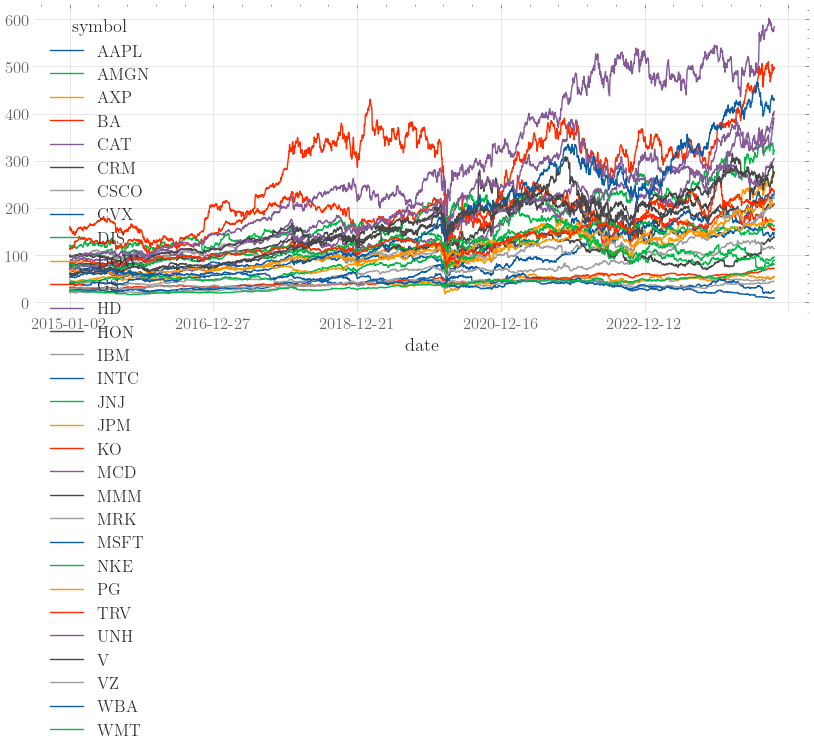

In [40]:
pivot[pivot.index>'2000-01-01'].plot(figsize=(10,4))

In [108]:
df_dax_train = df_dow.copy()
df_dax_train.sort_values(['date','tic'],ignore_index=True,inplace=True)
df_dax_train.index = df_dax_train.index.factorize()[0]

In [109]:
df_dax_train.dropna(inplace=True)
df_dax_train.head()


date       open       high        low      close     volume   tic  \
0  2000-01-03   0.936384   1.004464   0.907924   0.844004  535796800  AAPL   
1  2000-01-03  70.000000  70.000000  62.875000  44.614418   22914900  AMGN   
2  2000-01-03  47.995617  47.995617  45.515598  32.671795    6471267   AXP   
3  2000-01-03  41.437500  41.687500  39.812500  25.940279    2638200    BA   
4  2000-01-03  23.843750  24.500000  23.843750  12.763931    5055000   CAT   

   day  
0    0  
1    0  
2    0  
3    0  
4    0

Successfully added technical indicators
Successfully added turbulence index


# Env Creation for training and test

In [5]:
INDICATORS = [
    "close_21_ema",
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed_dax = fe.preprocess_data(df_dax)
processed_dax = processed_dax.copy()
processed_dax = processed_dax.fillna(0)
processed_dax = processed_dax.replace(np.inf,0)
train_data_dax = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data_dax = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data_dax.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 19, State Space: 77


In [18]:
processed_dax.head()

Unnamed: 0        date        open        high         low       close  \
0           0  2000-01-03   18.875000   19.125000   17.730000   13.199191   
1           1  2000-01-03  339.750000  344.000000  316.500000  125.670906   
2           2  2000-01-03   26.350000   26.600000   24.799999    8.991820   
3           3  2000-01-03   48.073044   48.614296   43.802071   22.548071   
4           4  2000-01-03   22.000000   23.666666   22.000000   15.798368   

    volume      tic  day  close_21_ema  close_5_ema  turbulence  
0   784844   ADS.DE    0     13.199191    13.199191         0.0  
1   814220   ALV.DE    0    125.670906   125.670906         0.0  
2  3137354   BAS.DE    0      8.991820     8.991820         0.0  
3  2648778  BAYN.DE    0     22.548071    22.548071         0.0  
4    33894   BEI.DE    0     15.798368    15.798368         0.0

In [6]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from agents.evn_mvo import StockPortfolioEnv

stock_dimension = len(train_data_dax.tic.unique())
state_space = stock_dimension
env_kwargs = {
    "initial_amount": 1000000, 
    "normalize_df":None,
    "features" :["close", "high", "low","turbulence",'close_5_ema'],
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = PortfolioOptimizationEnv(df = train_data_dax, **env_kwargs)

In [7]:

stock_dimension = len(train_data_dax.tic.unique())
state_space = stock_dimension
env_kwargs = {
    "initial_amount": 1000000, 
    "normalize_df":None,
    "features" :["close", "high", "low","turbulence",'close_5_ema'],
}


#Establish the training environment using StockTradingEnv() class
est = PortfolioOptimizationEnv(df = test_data_dax, **env_kwargs)

In [120]:
len(est._df.index.unique())

447

# PPO training
### trainin PPO Models on the train set and plotting results

In [32]:

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    metrics_df = None
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - time_window - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  # more descriptive condition for early termination to clarify the logic
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            # print(len(date_list))
            # print(len(asset_list))
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"]}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
            account_memory = df_account_value
            actions_memory = df_actions
        # add current state to state memory
        # state_memory=test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory,metrics_df

In [19]:
time_windows = [1,5,21]
results= {}
for i in time_windows:
    results["ppo_"+ str(i)] = {"i" : i}
results

{'ppo_1': {'i': 1}, 'ppo_5': {'i': 5}, 'ppo_21': {'i': 21}}

In [31]:
from finrl.agents.stablebaselines3.models import DRLAgent
time_windows = [1,5,21]
 
results= {}
for i in time_windows:
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }
    e_train_gym = PortfolioOptimizationEnv(df = train_data_dax, **env_kwargs)
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }

    est = PortfolioOptimizationEnv(df = test_data_dax, **env_kwargs)
    agent = DRLAgent(env = e_train_gym)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.0003,
        "batch_size": 128,
    }
    model_ppo = agent.get_model("ppo"
                                ,model_kwargs = PPO_PARAMS)
    ppo_model = agent.train_model(model=model_ppo, 
                                tb_log_name='ppo',
                                total_timesteps=80000)
    metrics_df_dax = pd.DataFrame(
        {
            "date": e_train_gym._date_memory,
            "actions": e_train_gym._actions_memory,
            "returns": e_train_gym._portfolio_return_memory,
            "rewards": e_train_gym._portfolio_reward_memory,
            "portfolio_values": e_train_gym._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(ppo_model, est,i)
    results["ppo_"+ str(i)] = {'train_df': metrics_df_dax,'test_df':ppo_predictions}

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| time/              |            |
|    fps             | 59         |
|    iterations      | 1          |
|    time_elapsed    | 34         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.00711112 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 2           |
|    time_elapsed         | 68          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014155014 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | 0.324      

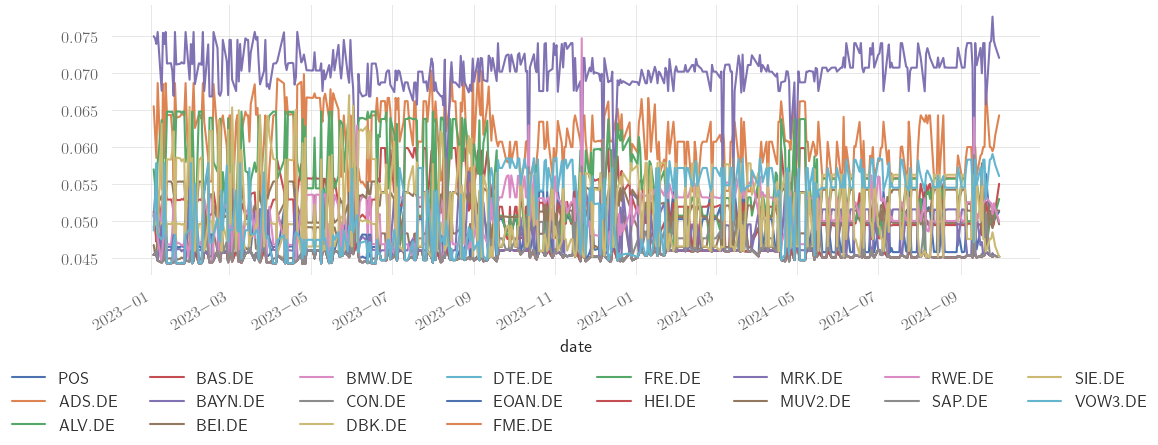

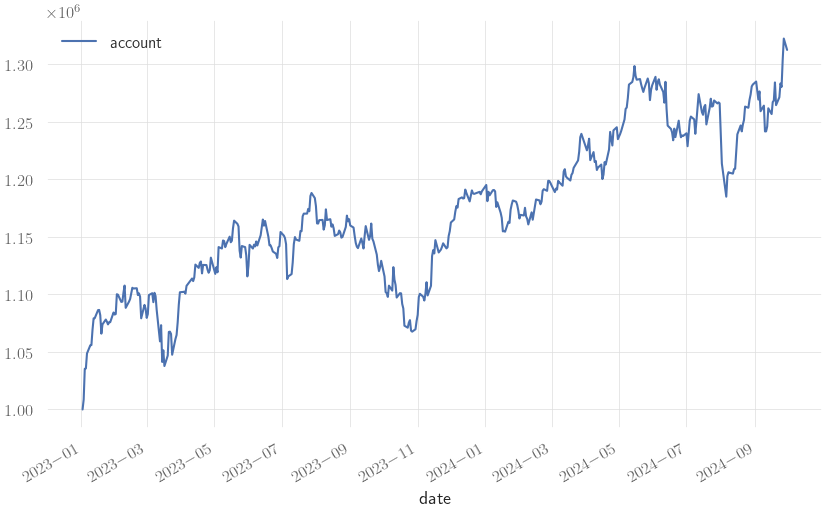

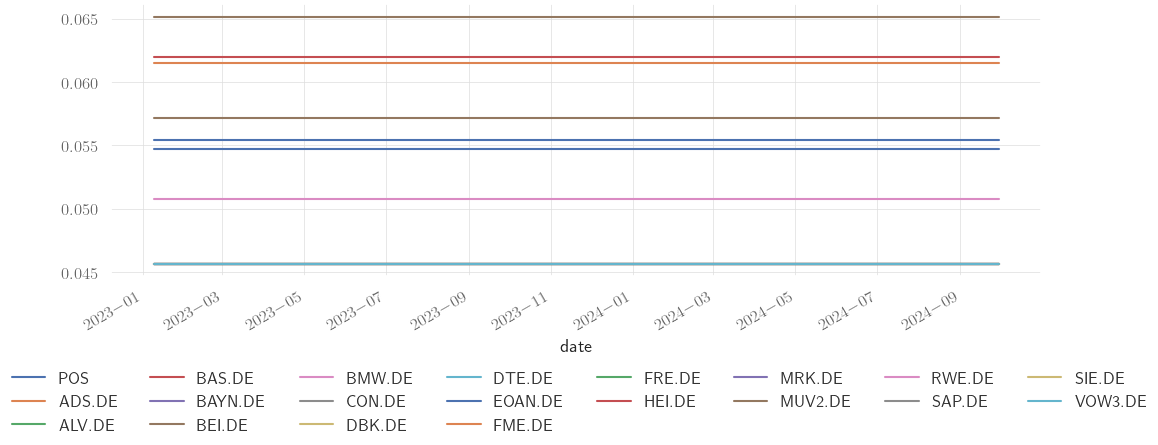

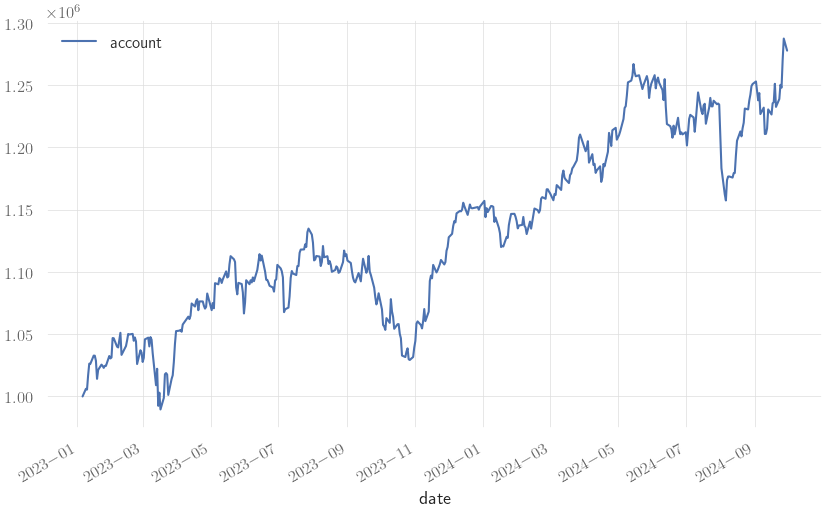

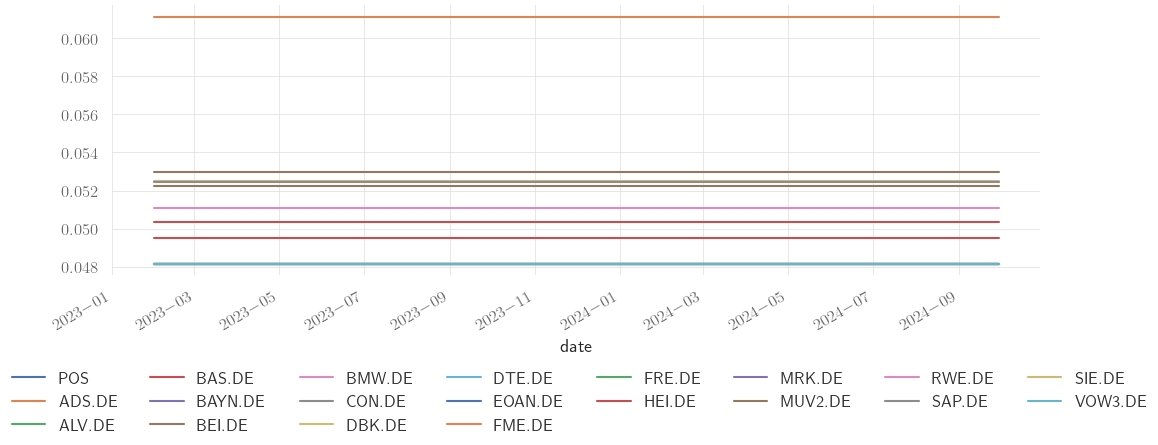

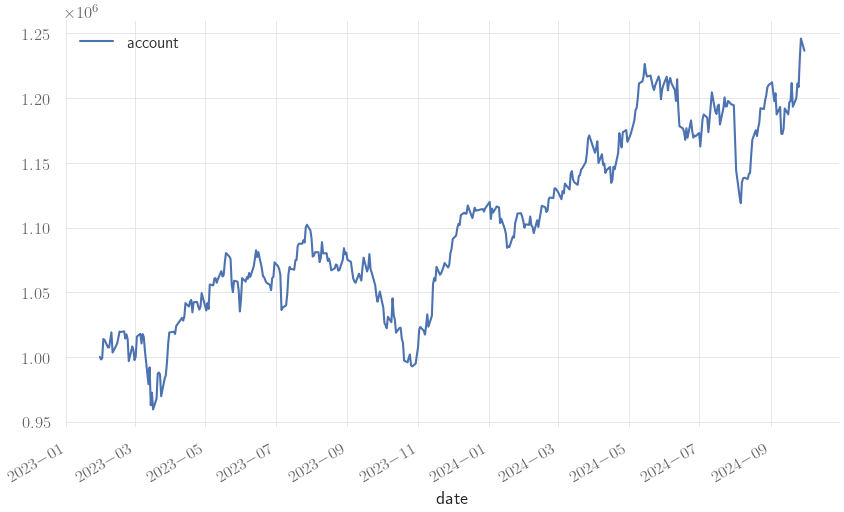

In [38]:
for item in results:    
    results[item]['test_df'][1].iloc[1:,].plot(figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    results[item]['test_df'][0].plot(x='date',y='account')
    

In [45]:
with open('./models/ppo.pkl','wb') as f:
    pickle.dump(results,f)

## Testing PPO on test set

In [14]:
est._actions_memory

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

# Actor Advantage Critic

## Training The Model

In [155]:
a2c_model = agent.get_model("a2c")
trained_a2c = agent.train_model(model=a2c_model, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------------
| time/                 |               |
|    fps                | 25            |
|    iterations         | 100           |
|    time_elapsed       | 19            |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -45.2         |
|    explained_variance | -0.0422       |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | -0.614        |
|    reward             | -0.0008983474 |
|    std                | 1.09          |
|    value_loss         | 0.000213      |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 25          |
|    iterations         | 200         |
|    time_elaps

In [47]:
from finrl.agents.stablebaselines3.models import DRLAgent
time_windows = [1,5,21]
 
results= {}
for i in time_windows:
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }
    e_train_gym = PortfolioOptimizationEnv(df = train_data_dax, **env_kwargs)
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",'close_5_ema'],
        "time_window" : i
    }

    est = PortfolioOptimizationEnv(df = test_data_dax, **env_kwargs)
    agent = DRLAgent(env = e_train_gym)
    model_a2c = agent.get_model("a2c")
    a2c_model = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=80000)
    metrics_df_dax = pd.DataFrame(
        {
            "date": e_train_gym._date_memory,
            "actions": e_train_gym._actions_memory,
            "returns": e_train_gym._portfolio_return_memory,
            "rewards": e_train_gym._portfolio_reward_memory,
            "portfolio_values": e_train_gym._asset_memory["final"],
        }
    )
    a2c_predictions = DRL_prediction(a2c_model, est,i)
    results["a2c_"+ str(i)] = {'train_df': metrics_df_dax,'test_df':a2c_predictions}

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------------
| time/                 |               |
|    fps                | 54            |
|    iterations         | 100           |
|    time_elapsed       | 9             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -29.8         |
|    explained_variance | -163          |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | 0.419         |
|    reward             | -0.0033638964 |
|    std                | 1.07          |
|    value_loss         | 0.00288       |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 55          |
|    iterations         | 200         |
|    time_elaps

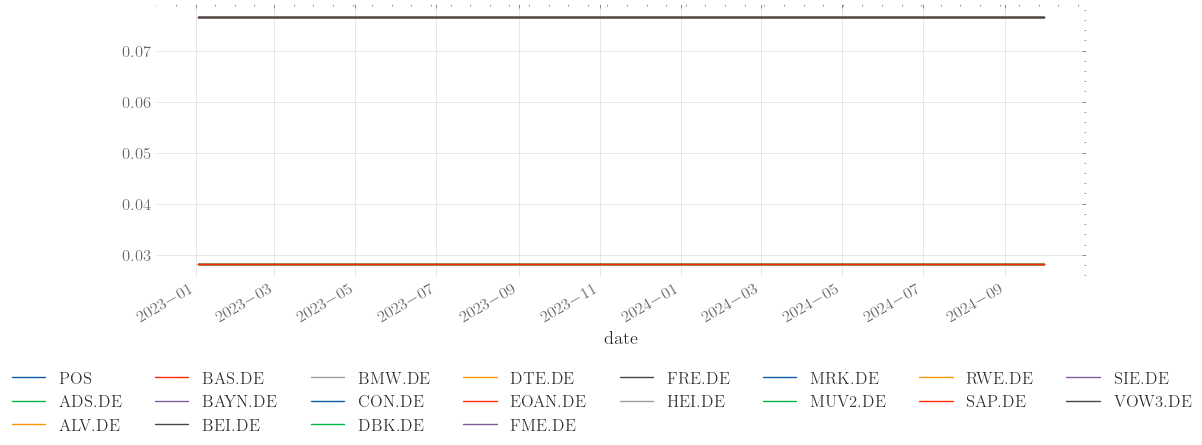

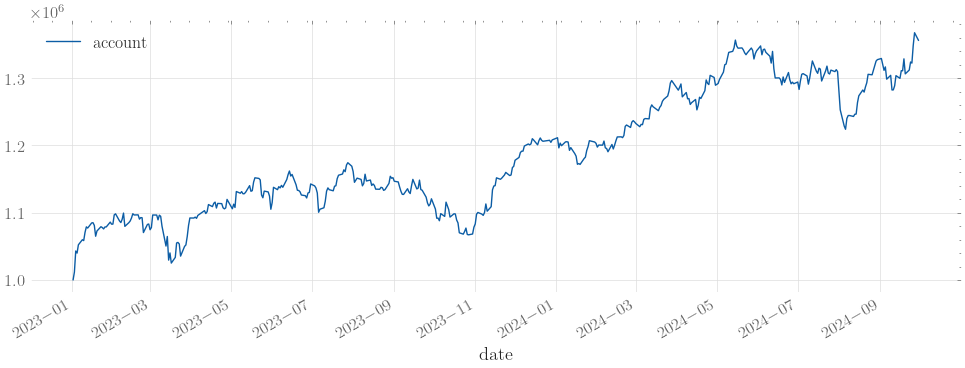

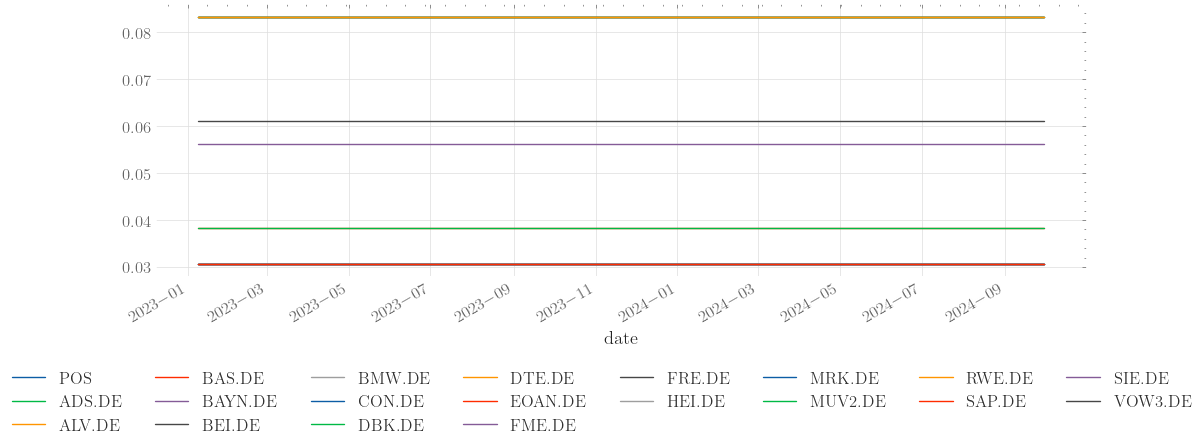

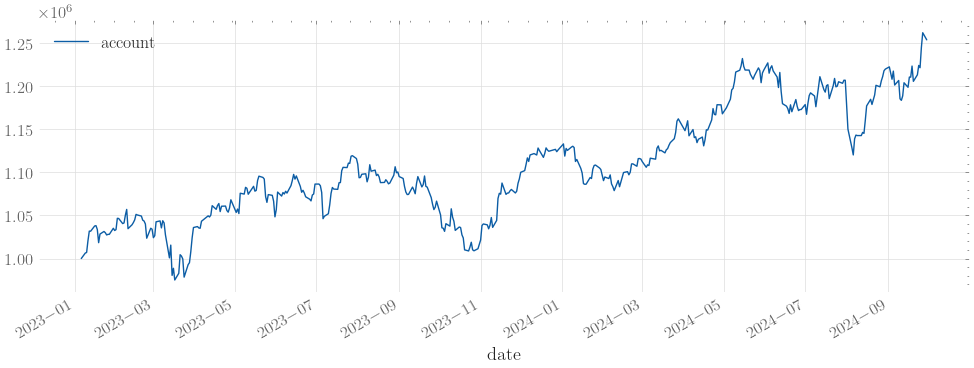

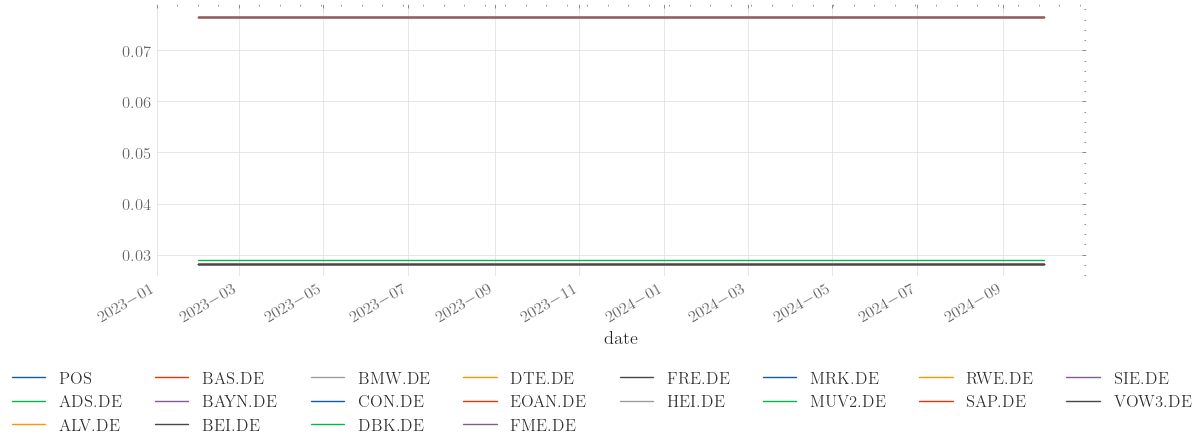

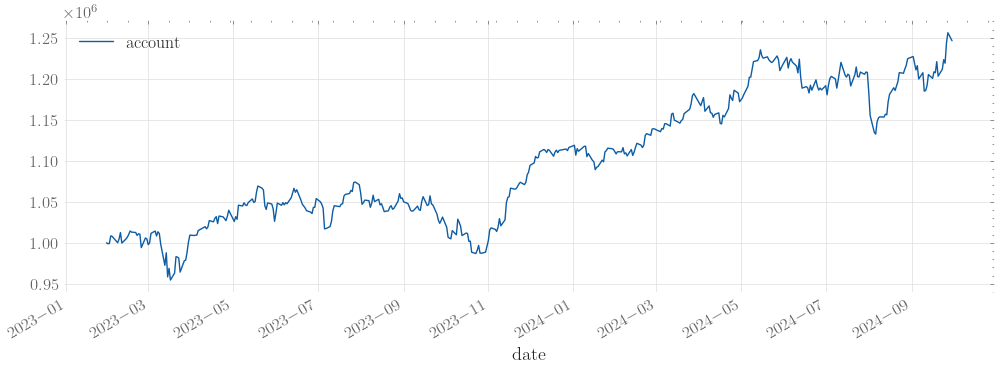

In [50]:
for item in results:    
    results[item]['test_df'][1].iloc[1:,].plot(figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    results[item]['test_df'][0].plot(x='date',y='account',figsize=(12,4))

In [52]:
with open('./models/a2c.pkl','wb') as f:
    pickle.dump(results,f)

# Buy and hold strategy

In [26]:
test_data_dax

Unnamed: 0        date        open        high         low       close  \
0         63237  2024-01-02  184.199997  186.600006  181.080002  181.666138   
0         63238  2024-01-02  242.899994  246.649994  242.699997  232.545197   
0         63239  2024-01-02   49.000000   49.474998   48.404999   45.798027   
0         63240  2024-01-02   33.794998   34.445000   33.715000   34.187199   
0         63241  2024-01-02  136.000000  136.149994  134.550003  134.004425   
..          ...         ...         ...         ...         ...         ...   
191       68607  2024-09-30   33.090000   33.180000   32.680000   32.680000   
191       68608  2024-09-30  204.550003  207.050003  204.399994  204.399994   
191       68609  2024-09-30  181.259995  183.580002  180.559998  181.339996   
191       68610  2024-09-30   33.000000   33.040001   32.389999   32.730000   
191       68611  2024-09-30   97.000000   97.339996   94.099998   95.160004   

      volume      tic  day  close_21_ema  close_5_ema  turbulence  
0     376060   ADS.DE    1    187.790171   184.418740   22.650663  
0     778095   ALV.DE    1    227.715707   230.461078   22.650663  
0    1778922   BAS.DE    1     43.983016    45.492149   22.650663  
0    3809729  BAYN.DE    1     33.050808    33.456149   22.650663  
0     127940   BEI.DE    1    132.023878   134.012515   22.650663  
..       ...      ...  ...           ...          ...         ...  
191  1951912   RWE.DE    0     32.420701    32.644584   18.315376  
191  1774113   SAP.DE    0    200.903332   204.547943   18.315376  
191  1595961   SIE.DE    0    170.486036   178.240275   18.315376  
191  2725760   VNA.DE    0     32.126941    32.502375   18.315376  
191  1676185  VOW3.DE    0     93.937649    94.929296   18.315376  

[4992 rows x 12 columns]

In [8]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data_dax,
    initial_amount=1000000,
    comission_fee_pct=0.0025,
    time_window=5,
    features = ["close", "high", "low",'close_21_ema','close_5_ema','turbulence'],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1275741.25
Final accumulative portfolio value: 1.27574125
Maximum DrawDown: -0.10386398758435511
Sharpe ratio: 1.190064758443195


In [9]:
buy_and_hold_train = environment_train_buy_and_hold._asset_memory["final"]
buy_and_hold_weights_train = environment_train_buy_and_hold._final_weights
buy_and_hold_weights_df = pd.DataFrame(buy_and_hold_weights_train)
buy_and_hold_account_df = pd.DataFrame(buy_and_hold_train,environment_train_buy_and_hold._date_memory)
buy_and_hold_weights_df.drop(buy_and_hold_weights_df.columns[0],axis=1,inplace=True)
buy_and_hold_weights_df.columns = test_data_dax.tic.unique()



In [30]:
buy_and_hold_weights_df.shape

(192, 26)

In [10]:
bah_dates = environment_train_buy_and_hold._date_memory

In [11]:
buy_and_hold_account_df.head()
buy_and_hold_account_df.columns = ['acc']

<Axes: >

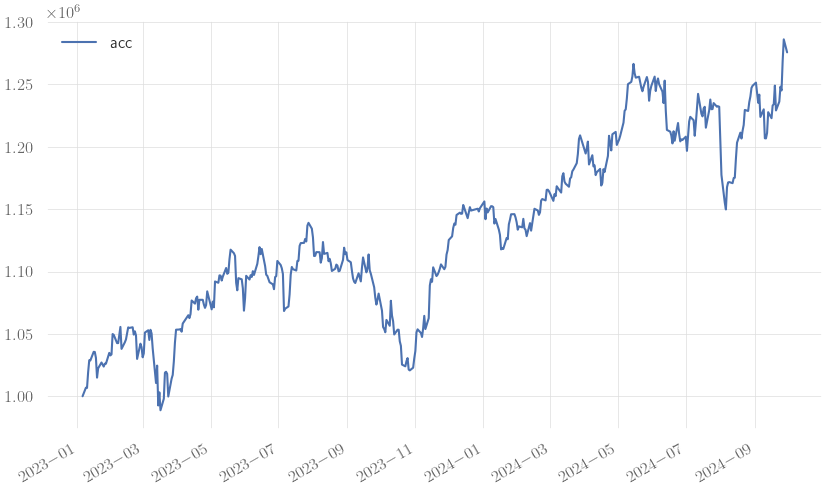

In [12]:
%matplotlib inline

buy_and_hold_account_df.plot()

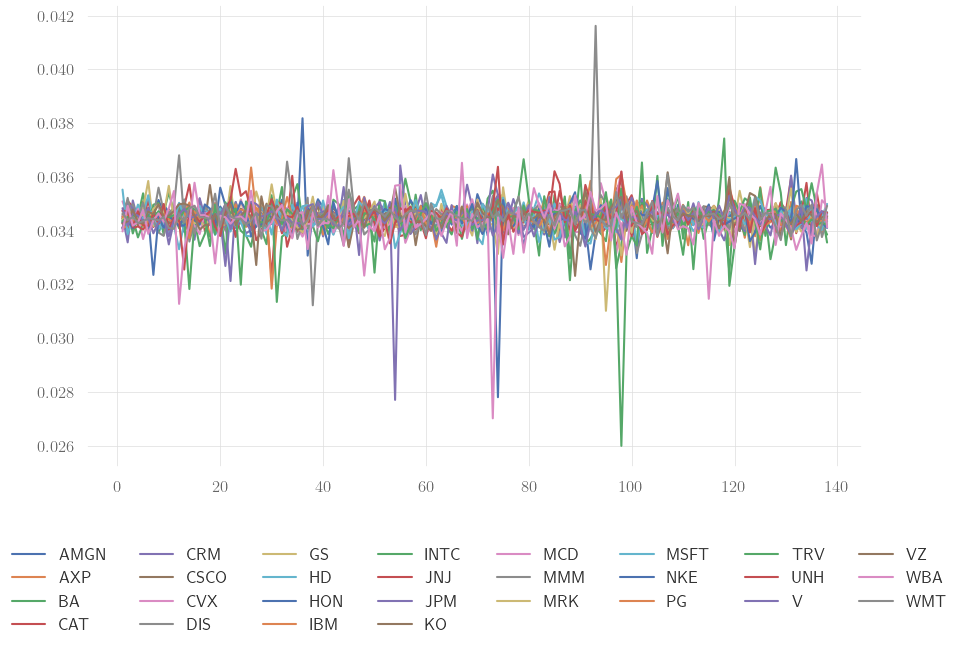

In [77]:
buy_and_hold_weights_df.head()
buy_and_hold_weights_df.iloc[1:,1:].plot().legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

In [18]:
columns = ['acc_value']
columns.extend(train_data.tic.unique())
columns.extend(train_data.tic.unique() + ['_holding'])
columns.extend(train_data.tic.unique()+['_ma'])

In [19]:
states_ppo = e_train_gym.state_memory
states_ppo_dates = e_train_gym.date_memory
states = np.array(states_ppo)
z2 = pd.DataFrame(states,columns= columns)
holdings = np.array(z2.iloc[:,1:stock_dimension+1]) * np.array(z2.iloc[:,stock_dimension+2 :2*(stock_dimension+1)])
hoding_df = pd.DataFrame(holdings,columns=z2.columns[1:stock_dimension+1].tolist())
total_portfolio_value = holdings.sum(axis=1).reshape(-1, 1)

ppo_weights = holdings /total_portfolio_value
weights_df = pd.DataFrame(ppo_weights, columns=z2.columns[1:stock_dimension + 1].tolist())



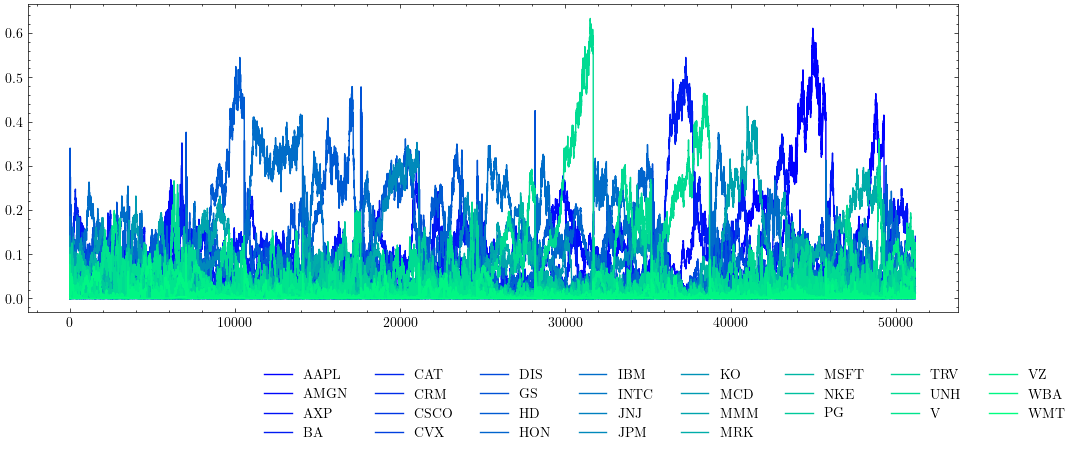

In [32]:
weights_df.plot(colormap="winter",figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))

# Mean Variance Optimization
## Data Preaparation

In [13]:
# add covariance matrix as states
df = df_dax.copy()
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

df["pct_change"] = df.groupby("tic").close.pct_change()

cov_list = []
# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :]
    price_lookback = data_lookback.pivot_table(
        index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values
    cov_list.append(covs)


In [14]:
df["mean_pct_change_lookback"] = df.rolling(lookback)["pct_change"].mean()
df["ewm_returns"] = df["pct_change"].ewm(span=50).mean()
df_cov = pd.DataFrame(
    {'time': df.date.unique()[lookback:], 'cov_list': cov_list})
df = df.merge(df_cov, left_on='date',right_on='time')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

In [15]:
df.head(3)

Unnamed: 0        date    open     high         low       close   volume  \
0        5242  2000-12-20   16.25   16.375   15.780000   12.048180  4267760   
1        5243  2000-12-20  377.00  382.750  376.100006  149.877899   452094   
2        5244  2000-12-20   23.15   24.100   23.150000    8.485009  4803590   

      tic  day  pct_change  mean_pct_change_lookback  ewm_returns        time  \
0  ADS.DE    2   -0.009091                 -0.000343     0.008833  2000-12-20   
1  ALV.DE    2   -0.009710                 -0.000391     0.008106  2000-12-20   
2  BAS.DE    2    0.004256                 -0.000355     0.007955  2000-12-20   

                                            cov_list  
0  [[0.0006859534169378296, 8.82196611406951e-05,...  
1  [[0.0006859534169378296, 8.82196611406951e-05,...  
2  [[0.0006859534169378296, 8.82196611406951e-05,...

# Mean Variance optimization

In [16]:

from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


test_df = data_split(
    df,
    start=TEST_START_DATE,
    end=TEST_END_DATE
)

stock_dimension = len(test_df.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.0025,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}
e_test_gym = StockPortfolioEnv(df=test_df, **env_kwargs)
agent = MarkowitzAgent(e_test_gym)
markowitz_history_df = agent.prediction(e_test_gym)
markowitz_history_df["method"] = "markowitz"

Stock Dimension: 28, State Space: 28
begin_total_asset:1000000
end_total_asset:1457901.8513011371
Sharpe:  1.7481870112924207
Test Finished!
episode_return 1.457901851301137


<Axes: xlabel='date'>

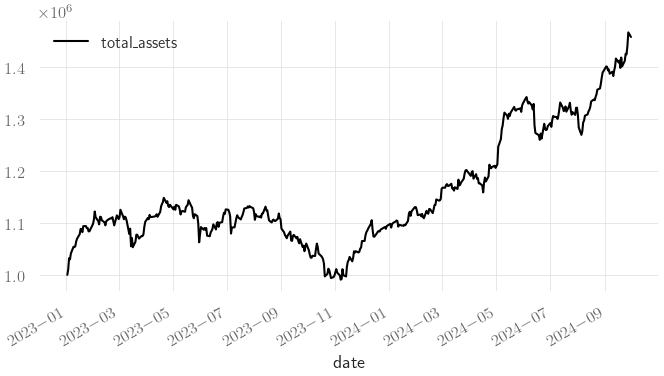

In [17]:
%matplotlib inline
markowitz_history_df.plot.line(x='date', y= 'total_assets',figsize=(8,4),color='black')

# Methods Comparison

# Dow Jones Industrial Average
The Dow Jones Industrial Average, Dow Jones, or simply the Dow, is a stock market index of 30 prominent companies listed on stock exchanges in the United States. The DJIA is one of the oldest and most commonly followed equity indexes. 


Constituents: 30

Exchanges: New York Stock Exchange; Nasdaq

Foundation: February 16, 1885; 139 years ago (as DJA); May 26, 1896 (as DJIA)

Market cap: US$12.0 trillion; (as of December 29, 2023)

Trading symbol: ^DJI; $INDU.DJI; DJIA

Weighting method: Price-weighted index

In [48]:
INDICATORS = [
    "close_62_ema",
    "close_21_ema",
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_dow)
processed = processed.copy()
processed = processed.fillna(0)
processed= processed.replace(np.inf,0)
train_data= data_split(processed, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed, TEST_START_DATE, TEST_END_DATE)


Successfully added technical indicators
Successfully added turbulence index


In [57]:
with open('./models/ppo_dow.pkl','wb') as f:
    pickle.dump(results,f)

## PPO

In [ ]:
from finrl.agents.stablebaselines3.models import DRLAgent
time_windows = [1,5,21]
MAS = [
    "close_5_ema",
    "close_21_ema",
    "close_62_ema",
]
PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.0003,
        "batch_size": 128,
}
results= {}
for i,v in enumerate(time_windows):
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",MAS[i]],
        "time_window" : v
    }
    e_train_gym = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    env_kwargs = {
        "initial_amount": 1000000, 
        "normalize_df":None,
        "features" :["close", "high", "low","turbulence",MAS[i]],
        "time_window" : v
    }

    est = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    agent = DRLAgent(env = e_train_gym)
    model = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
    trained_model = agent.train_model(model=model, 
                                tb_log_name='ppo',
                                total_timesteps=100000)
    metrics_df_dax = pd.DataFrame(
        {
            "date": e_train_gym._date_memory,
            "actions": e_train_gym._actions_memory,
            "returns": e_train_gym._portfolio_return_memory,
            "rewards": e_train_gym._portfolio_reward_memory,
            "portfolio_values": e_train_gym._asset_memory["final"],
        }
    )
    a2c_predictions = DRL_prediction(trained_model, est,v)
    results["a2c_"+ str(i)] = {'train_df': metrics_df_dax,'test_df':a2c_predictions}

0       0.000000
1      -0.005941
2      -0.006754
3      -0.009696
4      -0.009010
          ...   
2326    0.442617
2327    0.438354
2328    0.449040
2329    0.437614
2330    0.460937
Name: rewards, Length: 2331, dtype: float64
0       0.000000
1      -0.005941
2      -0.000813
3      -0.002942
4       0.000686
          ...   
2326    0.027296
2327   -0.004263
2328    0.010686
2329   -0.011425
2330    0.023323
Name: rewards, Length: 2331, dtype: float64


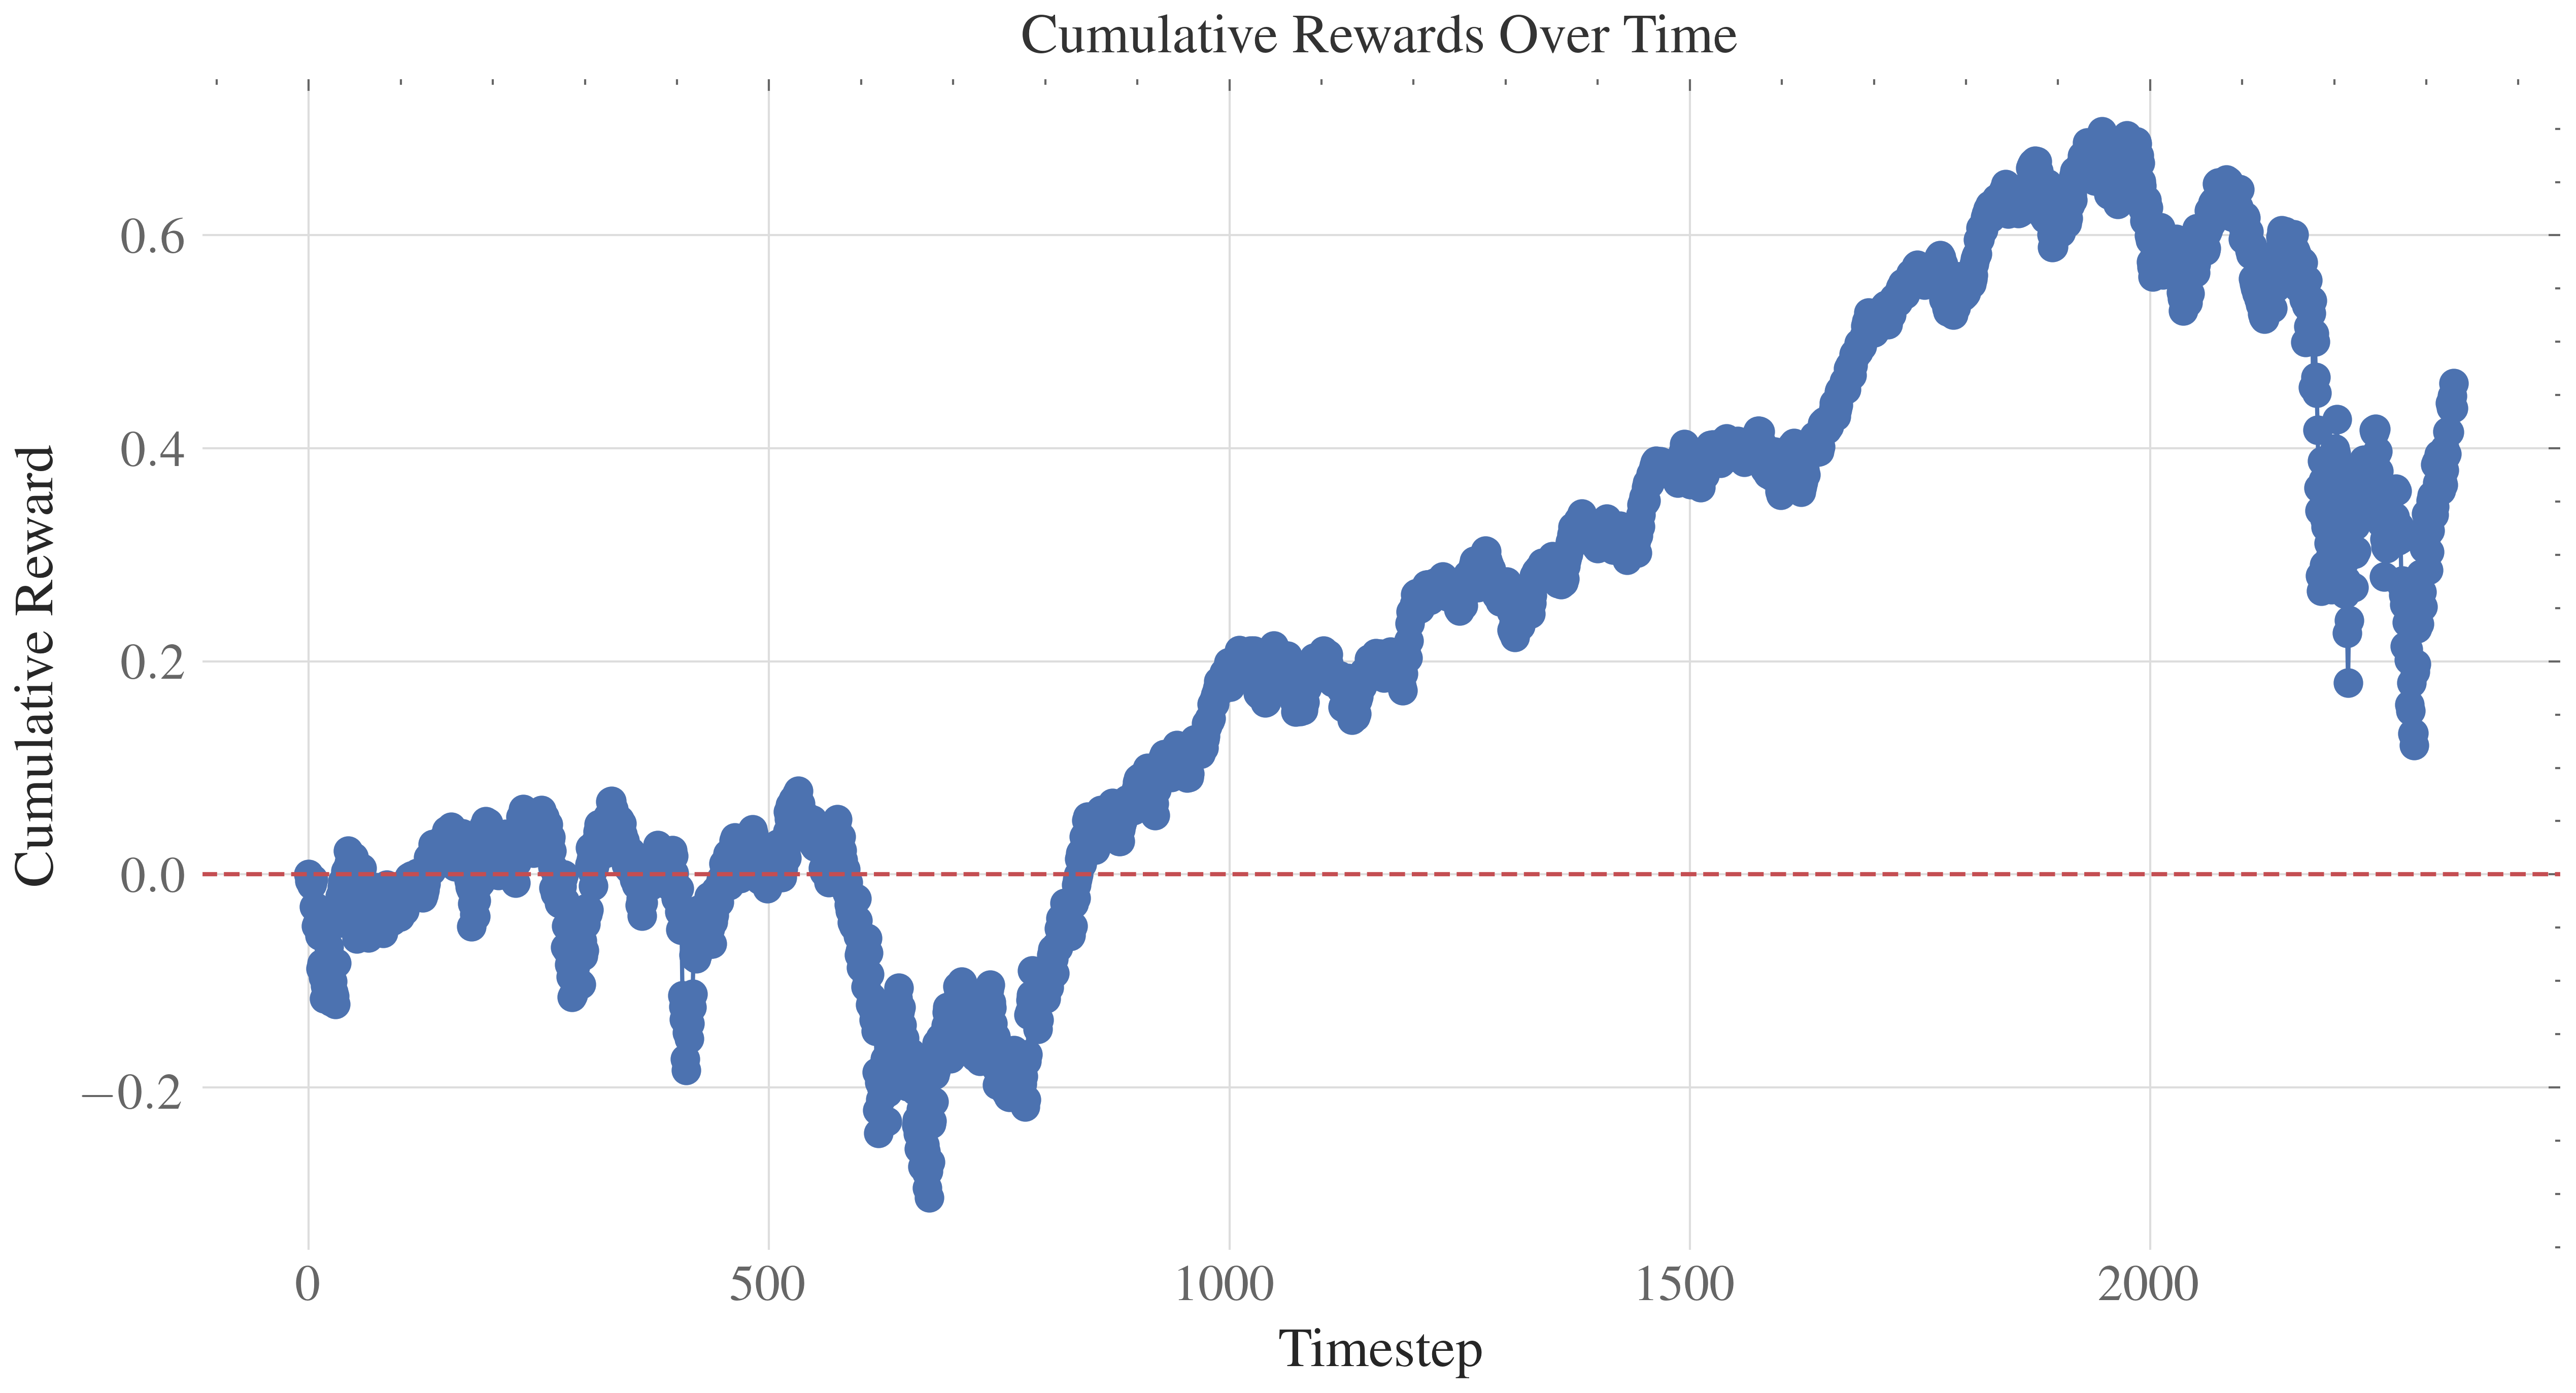

In [93]:
cumulative_rewards = np.cumsum(metrics_df_dax['rewards'])
print(cumulative_rewards)

print(metrics_df_dax['rewards'])

timesteps = np.arange(len(cumulative_rewards))

# Plot the cumulative rewards
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(timesteps, cumulative_rewards, marker='o', linestyle='-', color='b')
plt.title('Cumulative Rewards Over Time')
plt.xlabel('Timestep')
plt.ylabel('Cumulative Reward')
plt.axhline(0, color='r', linestyle='--', lw=1)  # Add a horizontal line at y=0 for reference
plt.grid(True)
plt.show()

In [80]:
trained_model.save('./results/ppo_dow')

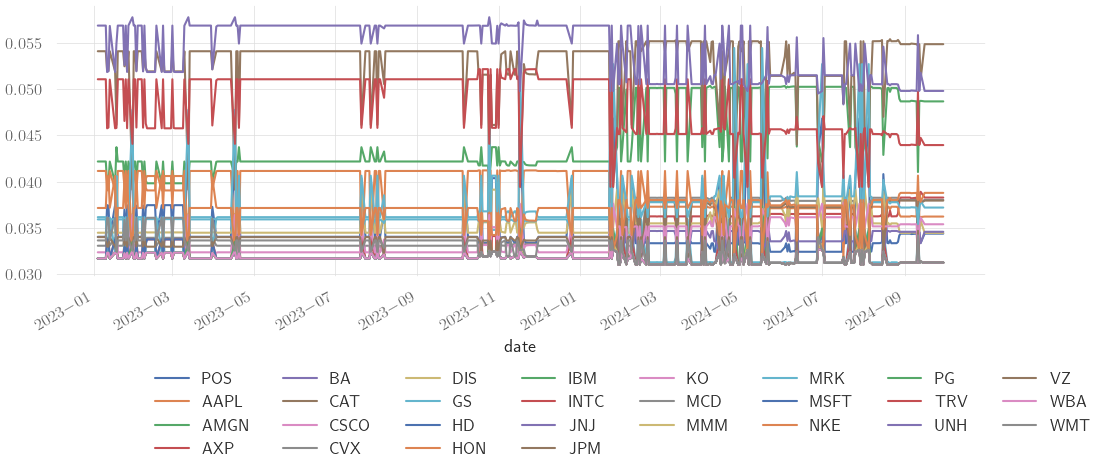

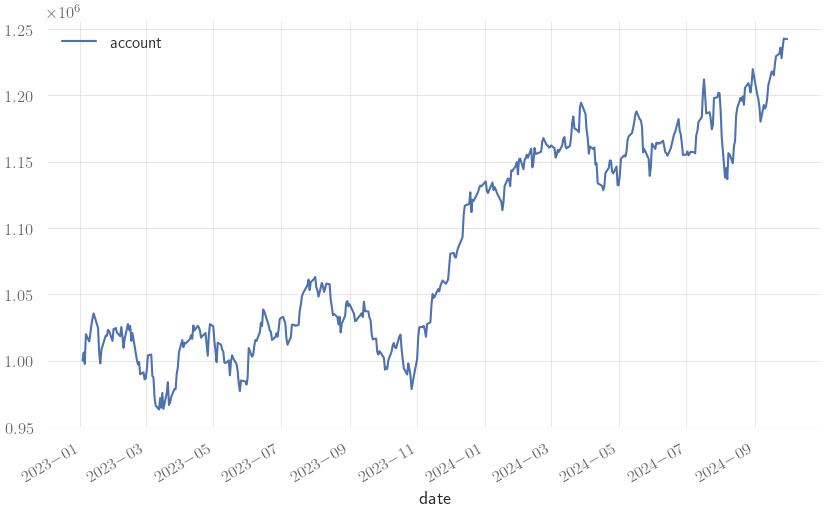

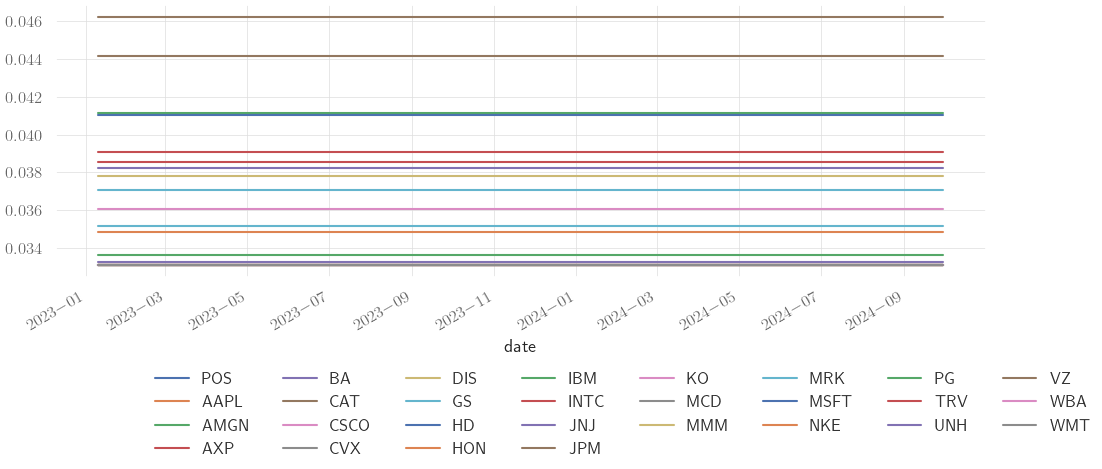

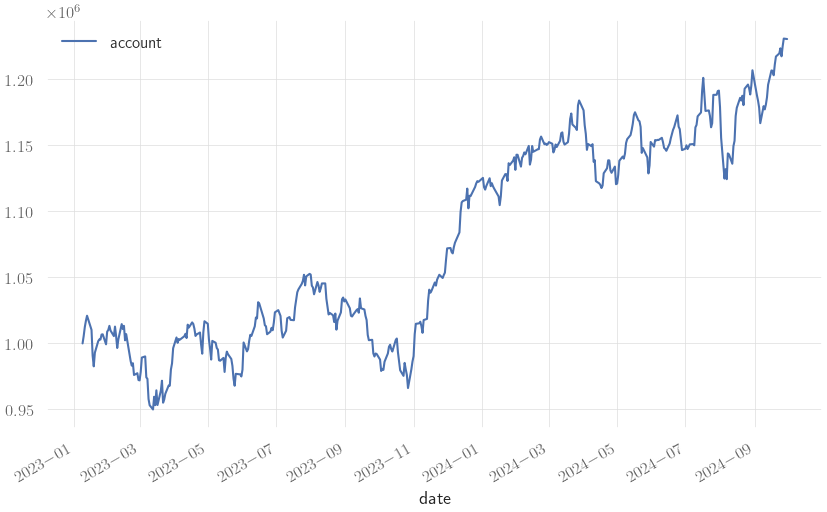

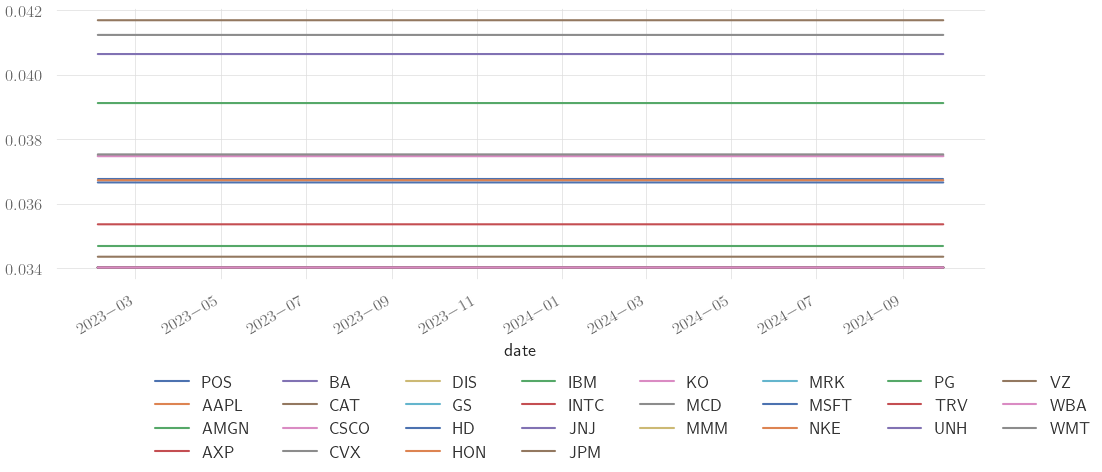

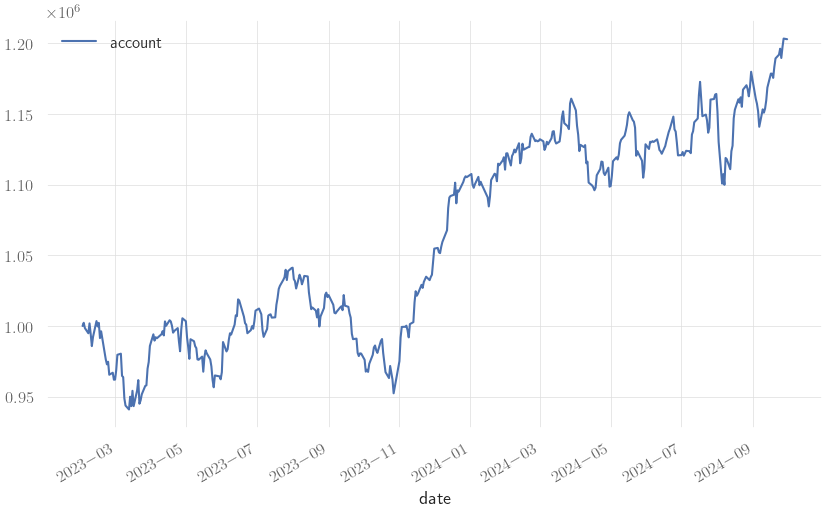

In [58]:
for item in results:    
    results[item]['test_df'][1].iloc[1:,].plot(figsize=(12,4)).legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    results[item]['test_df'][0].plot(x='date',y='account')

## buy and hold

In [83]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
stock_dimension = len(test_data.tic.unique())

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.0025,
    time_window=5,
    features = ["close", "high", "low",'close_21_ema','close_5_ema','turbulence'],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1210449.25
Final accumulative portfolio value: 1.21044925
Maximum DrawDown: -0.08852227115928024
Sharpe ratio: 1.0498526146489846


## MVO

In [60]:
# add covariance matrix as states
df = df_dow.copy()
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

df["pct_change"] = df.groupby("tic").close.pct_change()

cov_list = []
# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :]
    price_lookback = data_lookback.pivot_table(
        index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values
    cov_list.append(covs)
df["mean_pct_change_lookback"] = df.rolling(lookback)["pct_change"].mean()
df["ewm_returns"] = df["pct_change"].ewm(span=50).mean()
df_cov = pd.DataFrame(
    {'time': df.date.unique()[lookback:], 'cov_list': cov_list})
df = df.merge(df_cov, left_on='date',right_on='time')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)


In [61]:

from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent


test_df = data_split(
    df,
    start=TEST_START_DATE,
    end=TEST_END_DATE
)

stock_dimension = len(test_df.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.0025,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}
e_test_gym = StockPortfolioEnv(df=test_df, **env_kwargs)
agent = MarkowitzAgent(e_test_gym)
markowitz_history_df = agent.prediction(e_test_gym)
markowitz_history_df["method"] = "markowitz"

Stock Dimension: 30, State Space: 30
begin_total_asset:1000000
end_total_asset:1367834.1735384597
Sharpe:  1.4331763867626381
Test Finished!
episode_return 1.3678341735384596


<Axes: xlabel='date'>

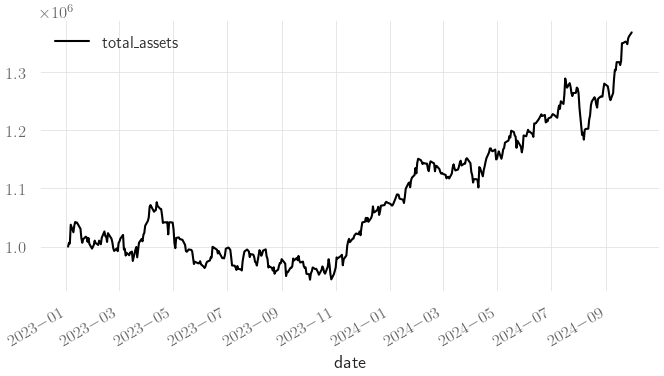

In [62]:
%matplotlib inline
markowitz_history_df.plot.line(x='date', y= 'total_assets',figsize=(8,4),color='black')

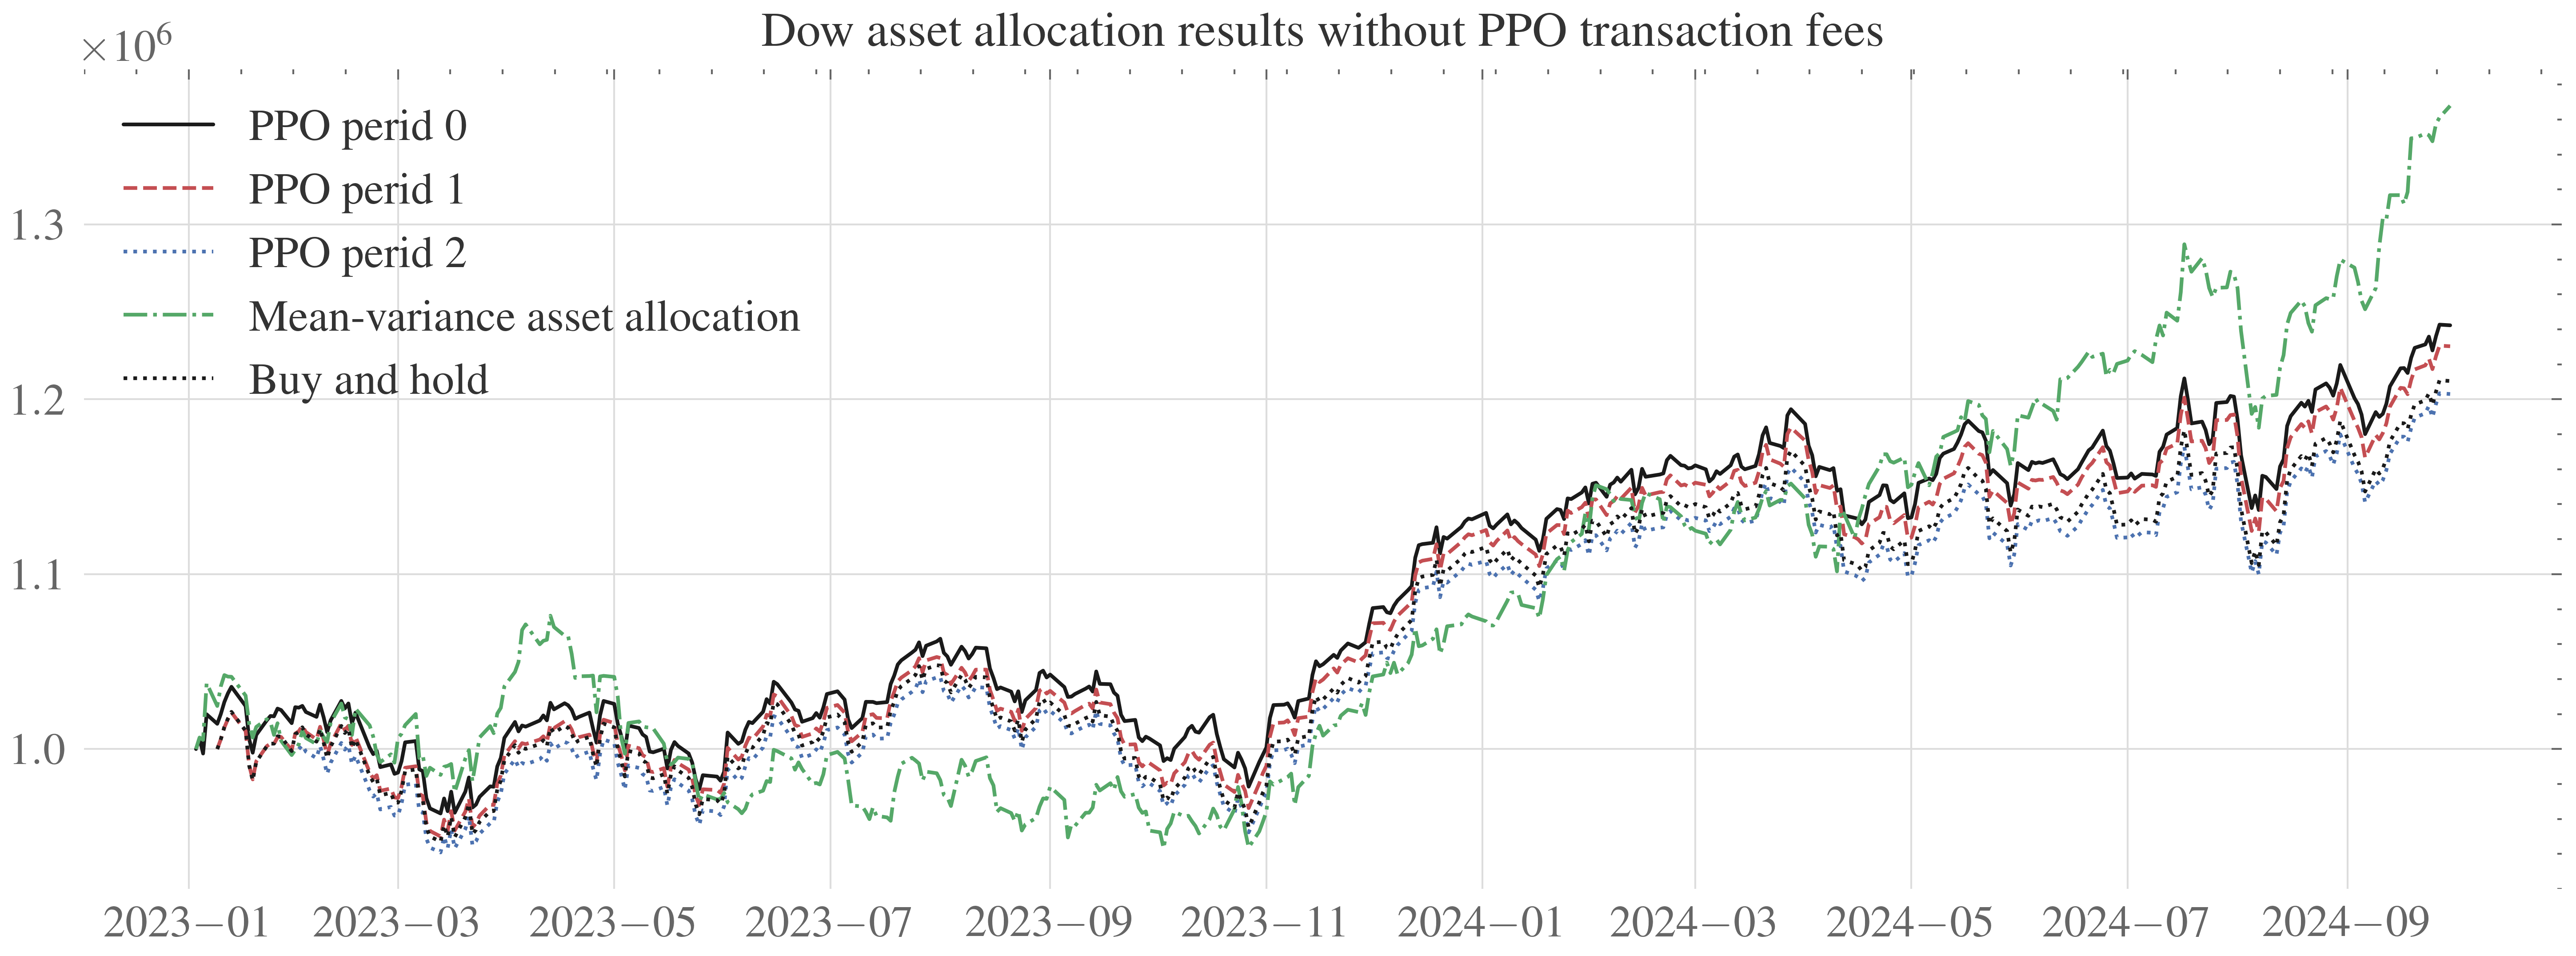

In [90]:
plt.style.use(['science','ieee'])
plt.figure(figsize=(12,4))
for i,item in enumerate(results):    
    plt.plot(results[item]['test_df'][0].get('date'),results[item]['test_df'][0].get('account'),label='PPO perid '+ str(i))
plt.plot(markowitz_history_df.get('date'),markowitz_history_df.get('total_assets'),label='Mean-variance asset allocation')
plt.plot(environment_train_buy_and_hold._date_memory,environment_train_buy_and_hold._asset_memory["final"],label = 'Buy and hold',linestyle = 'dotted')
plt.legend()
plt.title('Dow asset allocation results without PPO transaction fees')
plt.show()

# HSI

The Hang Seng Index is a market-capitalization-weighted stock market index in Hong Kong, adjusted for free float. It tracks and records daily changes in the largest companies listed on the Hong Kong Stock Exchange and serves as the primary indicator of overall market performance in Hong Kong.

Constituents: 82

Exchanges: Hong Kong Stock Exchange

Foundation: July 31, 1964; 60 years ago

Trading symbol: HSI

Weighting method: Capitalization-weighted